In [1]:
import numpy as np
import math
from math import pi
from math import cos, sin, tan
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

# DH Matrix of Robot

In [2]:
dof_n = 3 #number of dof
pose_variables_n = 16 #number of pose variables, e.g. 2 => planar, 3=> 3d pose, 6=> 3d pose + orientation
def robot_fwd_kin(joints):
    #robot parameters
    #l1 = 0.25 #m
    #l3 = 0.15 #m
    #first row 
    dh_11 = cos(joints[0])
    dh_12 = 0
    dh_13 = -1*sin(joints[0])
    dh_14 = -1*sin(joints[0])*joints[2]

    #second row
    dh_21 = sin(joints[0])
    dh_22 = 0
    dh_23 = cos(joints[0])
    dh_24 = cos(joints[0])*joints[2]

    #3rd row
    dh_31 = 0
    dh_32 = -1
    dh_33 = 0
    dh_34 = joints[1]+joints[2]

    #4th row
    dh_41 = 0
    dh_42 = 0
    dh_43 = 0
    dh_44 = 1
    
    return np.array([[dh_11, dh_12, dh_13, dh_14],
                     [dh_21, dh_22, dh_23, dh_24],
                     [dh_31, dh_32, dh_33, dh_34],
                     [dh_41, dh_42, dh_43, dh_44]])



# Data Generation Segment
This segment is used to generate the training and testing data then saving them in a pickle file, if the data is already generated and no edits are introduced, the user can skip this part


In [3]:
#user defined parameters
#data parameters
data_n = 5*(10**5) #size of vectors of data

#robot parametrs

d_max_range = 0.2 #m
d_min_range = 0   #m

theta_max_range = pi  #rad
theta_min_range = 0   #rad

#calculations
#joint variables
joint1 = np.random.uniform(low=theta_min_range, high=theta_max_range, size=(data_n,))
joint2 = np.random.uniform(low=d_min_range, high=d_max_range, size=(data_n,)) 
joint3 = np.random.uniform(low=d_min_range, high=d_max_range, size=(data_n,))


joints = np.array([joint1, joint2, joint3]).T


#pose calculation

p = np.empty((data_n,4,4))
for i in range(len(joints)):
    p_1 = robot_fwd_kin(joints[i])
    p[i] = p_1
    

p = p.reshape(-1,16)



#dumping the data, user must take care of sequence of dumping
with open('robot_set.pickle','wb') as f:
    pickle.dump([p, joints], f)
            #leave first 3 elements reserved, start your changes after them, there are the pose data, then the joints data

print('\ndata saved :)')


data saved :)


# Data Loading Segment

In [4]:
#data retrieval
with open("robot_set.pickle","rb") as f:
	all_data = pickle.load(f)

pose_data, joints_data = all_data[0], all_data[1]

del all_data

data_n = pose_data.shape[0] #update the size of data sets

test_size = int(0.35*data_n)

test_pose = pose_data[data_n-test_size:]
test_joints = joints_data[data_n-test_size:]

pose_data = np.delete(pose_data, list(range(data_n-test_size , pose_data.shape[0])), axis=0)
joints_data = np.delete(joints_data, list(range(data_n-test_size , joints_data.shape[0])), axis=0)


# Trajectory Data

In [5]:
points_n_t = 20
traj_joint = np.array([np.linspace(0,pi,points_n_t), np.linspace(0,0.2,points_n_t), np.linspace(0,0.2,points_n_t)]).T
p_t = np.empty((len(traj_joint),4,4))
for i in range(len(traj_joint)):
    p_1_t = robot_fwd_kin(traj_joint[i])
    p_t[i] = p_1_t
    
p_t_ip = p_t.reshape(-1,16)
px = p_t[:,0,3]
py = p_t[:,1,3]
pz = p_t[:,2,3]

# Neural Network Definition

In [6]:

n_nodes_hl1 = 64
n_nodes_hl2 = 64
n_nodes_hl3 = 64
n_nodes_hl4 = 64
n_nodes_hl5 = 64

#inpts and outputs
op_len = joints_data.shape[1]
ip_len = pose_data.shape[1]
x = tf.placeholder('float',shape=[None, ip_len ])
y = tf.placeholder('float')


def neural_network_model(data):
    hidden_1_layer = {'weights':tf.Variable(tf.random_normal([ip_len ,n_nodes_hl1])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl1]))
                      }

    hidden_2_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl1,n_nodes_hl2])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl2]))
                      }

    hidden_3_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl2,n_nodes_hl3])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl3]))
                      }

    hidden_4_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3,n_nodes_hl4])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl4]))
                      }
    
    hidden_5_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl4,n_nodes_hl5])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl5]))
                      }

    output_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl5,op_len])),
                      'biases':tf.Variable(tf.random_normal([op_len]))
                     }

    l1 = tf.add(tf.matmul(data,hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.sigmoid(l1)

    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.sigmoid(l2)

    l3 = tf.add(tf.matmul(l2,hidden_3_layer['weights']), hidden_3_layer['biases'])
    l3 = tf.nn.sigmoid(l3)

    l4 = tf.add(tf.matmul(l3,hidden_4_layer['weights']), hidden_4_layer['biases'])
    l4 = tf.nn.sigmoid(l4)
    
    l5 = tf.add(tf.matmul(l4,hidden_5_layer['weights']), hidden_5_layer['biases'])
    l5 = tf.nn.sigmoid(l5)
    
    output = tf.add(tf.matmul(l4,output_layer['weights']), output_layer['biases'])

    nodes = [hidden_1_layer, [hidden_2_layer], [hidden_3_layer],[hidden_4_layer],[output_layer]]

    return output,nodes	


# Training And Evaluation

In [19]:

n_epochs = 10000  #number of feed forward and back prop

batch_size = 2**9

alpha = 0.001  #learning rate, default 0.001

prediction,N = neural_network_model(x)
cost = tf.sqrt(tf.reduce_mean( tf.square(prediction-y) ))
optimizer = tf.train.AdamOptimizer(learning_rate=alpha).minimize(cost)
saver = tf.train.Saver()


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(n_epochs):
        epoch_loss = 0
        for i in range(0, ip_len , batch_size):
            batch_x = pose_data[i:i+batch_size]
            batch_y = joints_data[i:i+batch_size]
            _,c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
            epoch_loss += c
        print('Epoch', epoch, 'completed out of',n_epochs,'loss:',epoch_loss)
        #print('predection:', prediction.eval({x:batch_x[0:1]}))
        #print('truth', batch_y[0:1])
        #print('diff:',prediction.eval({x:batch_x[0:1]})-batch_y[0:1])

    print('error :',sum(abs(prediction.eval({x:batch_x[0:1]})-batch_y[0:1])))

    print('\ntesting :')
    test_loss = sess.run([cost], feed_dict={x: test_pose, y: test_joints})
    print('test_loss:',test_loss)
    
    result = prediction.eval({x: test_pose})
    actual = test_joints
    
    joints_pred = prediction.eval({x: p_t_ip})
    p_pred = np.empty((len(joints_pred),4,4))
    for i in range(len(joints_pred)):
        p_1_pred = robot_fwd_kin(joints_pred[i])
        p_pred[i] = p_1_pred
    
    px_pred = p_pred[:,0,3]
    py_pred = p_pred[:,1,3]
    pz_pred = p_pred[:,2,3]

Epoch 0 completed out of 10000 loss: 4.83391666412
Epoch 1 completed out of 10000 loss: 4.58234262466
Epoch 2 completed out of 10000 loss: 4.33080530167
Epoch 3 completed out of 10000 loss: 4.08385848999
Epoch 4 completed out of 10000 loss: 3.84462594986
Epoch 5 completed out of 10000 loss: 3.61473917961
Epoch 6 completed out of 10000 loss: 3.39427137375
Epoch 7 completed out of 10000 loss: 3.18183898926
Epoch 8 completed out of 10000 loss: 2.97517251968
Epoch 9 completed out of 10000 loss: 2.77151894569
Epoch 10 completed out of 10000 loss: 2.5682091713
Epoch 11 completed out of 10000 loss: 2.36313152313
Epoch 12 completed out of 10000 loss: 2.15498805046
Epoch 13 completed out of 10000 loss: 1.94342172146
Epoch 14 completed out of 10000 loss: 1.72906756401
Epoch 15 completed out of 10000 loss: 1.51356589794
Epoch 16 completed out of 10000 loss: 1.29959762096
Epoch 17 completed out of 10000 loss: 1.09103214741
Epoch 18 completed out of 10000 loss: 0.893414139748
Epoch 19 completed out

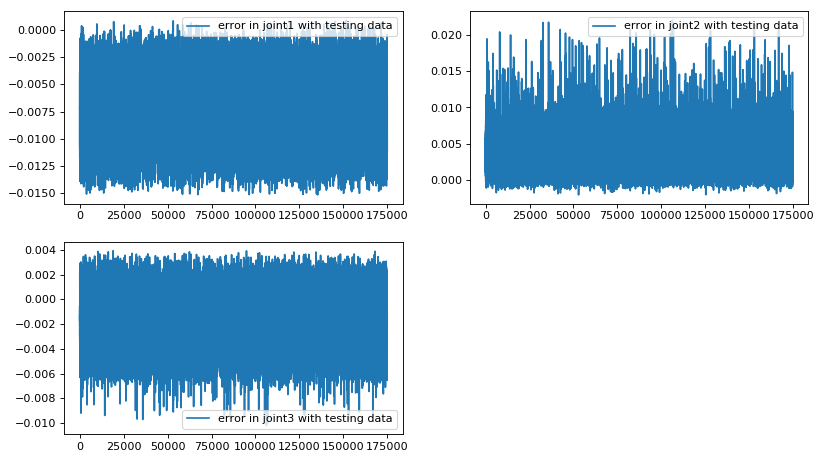

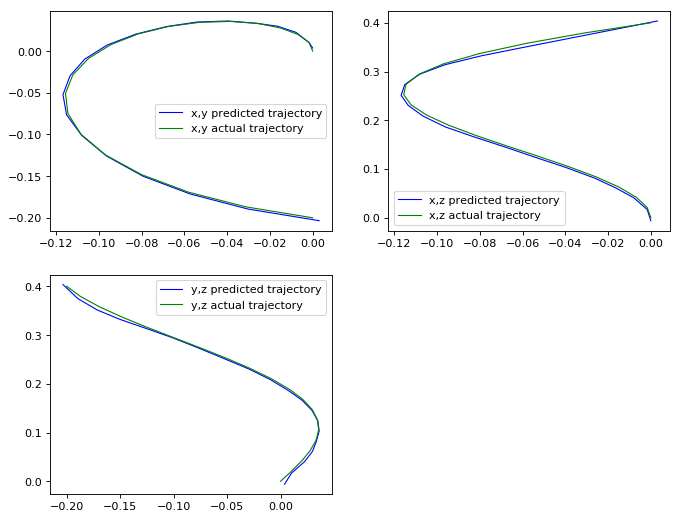

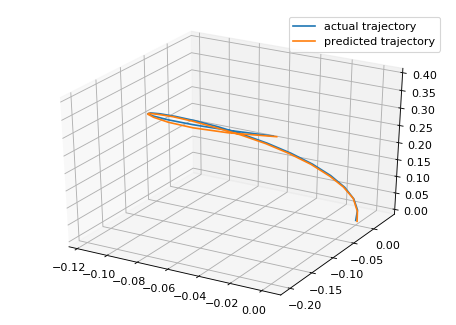

In [20]:
plt.figure(1,figsize=(12,7), dpi=80)
plt.subplot(2,2,1)
plt.plot(actual[:,0]-result[:,0], label='error in joint1 with testing data')
plt.legend()

plt.subplot(2,2,2)
plt.plot(actual[:,1]-result[:,1], label='error in joint2 with testing data')
plt.legend()

plt.subplot(2,2,3)
plt.plot(actual[:,2]-result[:,2], label='error in joint3 with testing data')
plt.legend()

plt.figure(2,figsize=(10,8), dpi=80)

plt.subplot(2,2,1)
plt.plot(px_pred, py_pred, color="blue", linewidth=1.0, linestyle="-", label='x,y predicted trajectory')
plt.plot(px, py, color="green", linewidth=1.0, linestyle="-", label='x,y actual trajectory')
plt.legend()

plt.subplot(2,2,2)
plt.plot(px_pred, pz_pred, color="blue", linewidth=1.0, linestyle="-", label='x,z predicted trajectory')
plt.plot(px, pz, color="green", linewidth=1.0, linestyle="-", label='x,z actual trajectory')
plt.legend()

plt.subplot(2,2,3)
plt.plot(py_pred, pz_pred, color="blue", linewidth=1.0, linestyle="-", label='y,z predicted trajectory')
plt.plot(py, pz, color="green", linewidth=1.0, linestyle="-", label='y,z actual trajectory')
plt.legend()

fig = plt.figure(figsize=(7,5), dpi=80)
ax = fig.gca(projection='3d')
ax.plot(px, py, pz, label='actual trajectory')
ax.plot(px_pred, py_pred, pz_pred, label='predicted trajectory')
ax.legend()

plt.show()

In [12]:
2**14


16384